# Hi sklearn!

Diving into machine learning.

In [1]:
import numpy

## Hello Astropy

`astropy` is an astronomy and astrophysics package that we'll use to operate with data.

Another python library for data manipulation is `pandas` which is popular among data scientists. 

Looking at the data

In [2]:
!head -n5 data/training.csv

MONTH,DAY,DAY_OF_WEEK,AIRLINE_ID,FLIGHT_NUMBER_ID,TAIL_NUMBER_ID,ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
9,26,6,4,4429,70,683,637,620,468,806,-14.0
8,27,4,13,139,1629,571,722,1705,991,1845,7.0
10,4,7,7,3185,2041,214,2,2010,1118,2220,118.0
4,22,3,5,742,4284,571,725,1229,602,1320,14.0


### Read the data

In [3]:
import astropy
from astropy.table import Table
from astropy.io import ascii
data = ascii.read("data/training.csv", delimiter=',')  
test_kaggle = ascii.read("data/test.csv", delimiter=',')  

In [4]:
data[:5] # python slicing works as usual

MONTH,DAY,DAY_OF_WEEK,AIRLINE_ID,FLIGHT_NUMBER_ID,TAIL_NUMBER_ID,ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64
9,26,6,4,4429,70,683,637,620,468,806,-14.0
8,27,4,13,139,1629,571,722,1705,991,1845,7.0
10,4,7,7,3185,2041,214,2,2010,1118,2220,118.0
4,22,3,5,742,4284,571,725,1229,602,1320,14.0
12,9,3,0,1626,1326,572,537,1830,1217,2222,3.0


In [5]:
type(data)

astropy.table.table.Table

In [6]:
# take a column
target = data['ARRIVAL_DELAY']
target

-14.0
7.0
118.0
14.0
3.0
-7.0
3.0
-25.0
-22.0
3.0
8.0


In [7]:
type(target)

astropy.table.column.Column

In [8]:
# can be converted to numpy.array at any moment
target = numpy.array(target)
type(target)

numpy.ndarray

### remove target column from dataset

In [9]:
data.remove_column('ARRIVAL_DELAY')
data[:5]

MONTH,DAY,DAY_OF_WEEK,AIRLINE_ID,FLIGHT_NUMBER_ID,TAIL_NUMBER_ID,ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
9,26,6,4,4429,70,683,637,620,468,806
8,27,4,13,139,1629,571,722,1705,991,1845
10,4,7,7,3185,2041,214,2,2010,1118,2220
4,22,3,5,742,4284,571,725,1229,602,1320
12,9,3,0,1626,1326,572,537,1830,1217,2222


### create binary target
late = 1, in time = 0

In [10]:
target

array([ -14.,    7.,  118., ...,   -7.,   18.,  -10.])

In [11]:
binary_target = (target > 10) * 1
binary_target

array([0, 0, 1, ..., 0, 1, 0])

### indexing
rows by index, columns by name

In [12]:
data[[1, 4, 6, 10]][['ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']]

ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID
int64,int64
571,722
572,537
506,616
763,709


In [13]:
# take first 5 rows in inverted order
data[:5][::-1]

MONTH,DAY,DAY_OF_WEEK,AIRLINE_ID,FLIGHT_NUMBER_ID,TAIL_NUMBER_ID,ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
12,9,3,0,1626,1326,572,537,1830,1217,2222
4,22,3,5,742,4284,571,725,1229,602,1320
10,4,7,7,3185,2041,214,2,2010,1118,2220
8,27,4,13,139,1629,571,722,1705,991,1845
9,26,6,4,4429,70,683,637,620,468,806


In [14]:
len(data), len(test_kaggle)

(499866, 200000)

### take small part of data
with a step of 20

In [15]:
small_data = data[::20]
small_binary_target = binary_target[::20]
small_target = target[::20]
print len(small_data)

24994


## Challenge is [flight delay prediction](https://inclass.kaggle.com/c/late-arrival-of-flights) 
The goal of this competition is to learn if flight is delayed (ARRIVAL_DELAY > 10) or not.

Performance of your model will be assessed by kaggle using the predictions on the unlabeled data.

### Prepare solution

define useful supplementary function to create solution file (you can just use it without understanding how it works).

In [16]:
from IPython.display import FileLink

def create_solution(predictions, filename='flight-delay-predictions.csv'):
    result = astropy.table.Table({'ID': numpy.arange(len(predictions)), 'ARRIVAL_DELAY': predictions})
    result.write('data/{}'.format(filename), format='csv', delimiter=',', overwrite=True)
    return FileLink('data/{}'.format(filename))

## Classification quality measure — area under the ROC curve (AUC)
[Demonstration](http://arogozhnikov.github.io/RocCurve.html) of roc curve was shown on the first lecture

In [17]:
# ROC AUC
from sklearn.metrics import roc_auc_score

## Simple solution with k-nearest neighbors

sklearn doesn't support astropy. Tables yet, so we'll use always `to_pandas` to convert it to pandas.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=1)
# convert astropy table to pandas before call the fit method
knn_clf.fit(small_data.to_pandas(), small_binary_target) # train an algorithm
roc_auc_score(small_binary_target, knn_clf.predict_proba(small_data.to_pandas())[:, 1])

1.0

In [19]:
create_solution(knn_clf.predict_proba(test_kaggle.to_pandas())[:, 1])

/Users/antares/Yandex.Disk.localized/2017-04-Heidelberg/practice/data/flight-delay-predictions.csv

Send it to kaggle and check that its score differs from the above value _significantly_.

## Cross validation 

Solution to this problem:

Divide into training and test samples. Train the classifier on training part of data and test its quality on test part not used in training process.

In [20]:
def train_test_split(*arrays, **kargs):
    '''modification of sklearn's train_test_split to support astropy. See sklearn documentation for parameters '''
    from sklearn.cross_validation import train_test_split
    arrays2 = map(lambda x: numpy.array(x) if isinstance(x, Table) else x, arrays)
    results = list(train_test_split(*arrays2, **kargs))
    
    for i in range(len(results) // 2):
        if isinstance(arrays[i], Table):
            results[2 * i] = Table(results[2 * i])
            results[2 * i + 1] = Table(results[2 * i + 1])
    return results

In [21]:
trainX, testX, trainY, testY = train_test_split(small_data, small_binary_target, random_state=42, train_size=0.5)

/Users/antares/.virtualenvs/rep/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Knn

In [22]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(trainX.to_pandas(), trainY)
print 'train', roc_auc_score(trainY, knn_clf.predict_proba(trainX.to_pandas())[:, 1])
print 'test', roc_auc_score(testY, knn_clf.predict_proba(testX.to_pandas())[:, 1])

train 1.0
test 0.515724003542


situation above is called 'overfitting'

## Sidenote: sklearn interface

In [23]:
# work with scikit-learn models in most cases consists of 
# 1. defining model with parameters
knn_clf = KNeighborsClassifier(n_neighbors=3)
# 2. training (method fit, X of shape [n_samples, n_features], target y of shape [n_samples])
knn_clf.fit(trainX.to_pandas(), trainY)
# 3. predicting (predict probabilities for classification)
knn_clf.predict_proba(testX.to_pandas())

array([[ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       ..., 
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

## Finding optimal number of neighbours:

In [24]:
# iterate over different number of neighbors
for n_neighbors in [1, 2, 4, 8, 16, 32, 64]:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(trainX.to_pandas(), trainY)
    print n_neighbors, roc_auc_score(testY, knn_clf.predict_proba(testX.to_pandas())[:, 1]), \
        '\t', roc_auc_score(trainY, knn_clf.predict_proba(trainX.to_pandas())[:, 1])    

1 0.515724003542 	1.0
2 0.526811467497 	0.922527160525
4 0.54385364353 	0.836041376766
8 0.554350463052 	0.770431087689
16 0.568701112664 	0.711185140986
32 0.57881120485 	0.67360327604
64 0.582053100751 	0.643523303279


### Standard scaler

Process input data: provide zero mean and std=1 for each feature 

In [25]:
from sklearn.preprocessing import StandardScaler
# first, standartize all features by shifting and scaling (mean = 0, std = 1)
scaler = StandardScaler().fit(trainX.to_pandas())
trainX_scaled = scaler.transform(trainX.to_pandas())
testX_scaled = scaler.transform(testX.to_pandas())
# output of scaling is numpy.array, now converting back to Table
trainX_scaled = Table(scaler.transform(trainX.to_pandas()), names=small_data.columns)
testX_scaled = Table(scaler.transform(testX.to_pandas()), names=small_data.columns)

In [26]:
for n_neighbors in [1, 2, 4, 8, 16, 32, 64]:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(trainX_scaled.to_pandas(), trainY)
    print n_neighbors, roc_auc_score(testY, knn_clf.predict_proba(testX_scaled.to_pandas())[:, 1])

1 0.530946033393
2 0.543929090477
4 0.562990995018
8 0.564800935286
16 0.57561686339
32 0.593083645699
64 0.602982266949


### Use canberra distance to avoid scaling of features

In [27]:
for n_neighbors in [1, 2, 4, 8, 16, 32, 64]:
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric='canberra')
    knn_clf.fit(trainX.to_pandas(), trainY)
    print n_neighbors, roc_auc_score(testY, knn_clf.predict_proba(testX.to_pandas())[:, 1])

1 0.53829562693
2 0.544101786254
4 0.565883054853
8 0.589069922951
16 0.594384113305
32 0.603033424553
64 0.616011049457


## Linear regression + Ridge regularization

Linear model is a very simple approximation:
$$\hat{y}_i = w_0 + \sum_j w_j x_i^j $$
where $x_i^j$ is a value for $j$-th feature of $i$-th sample, $w_j$ — is a parameter to find for $j$-th feature, $\hat{y}_i$ — prediction of linear model for $i$-th sample.

And we can introduce the loss function (how our approximation is far from the true values). For example:
$$\mathcal{L} = \sum_i (y_i - \hat{y}_i)^2 \to \min$$
(widely known as ordinary least squares)

In [28]:
from sklearn.linear_model import Ridge

In [29]:
ridge_clf = Ridge()
ridge_clf.fit(trainX.to_pandas(), trainY)
# use `predict` method for regression methods to evaluate function for new data
# output of predict are real values
print 'train', roc_auc_score(trainY, ridge_clf.predict(trainX.to_pandas()))
print 'test',  roc_auc_score(testY,  ridge_clf.predict(testX.to_pandas()))

train 0.60739242261
test 0.602154911148


Look at the coefficients

In [30]:
for k, v in zip(trainX.colnames, ridge_clf.coef_):
    print k, v

MONTH -0.00396642025042
DAY -0.000849598509233
DAY_OF_WEEK 0.000522607596815
AIRLINE_ID 0.0023244382386
FLIGHT_NUMBER_ID 2.31166829843e-06
TAIL_NUMBER_ID -6.63631363104e-06
ORIGIN_AIRPORT_ID -8.30802362578e-06
DESTINATION_AIRPORT_ID 7.78579842842e-05
SCHEDULED_DEPARTURE 9.87114931859e-05
DISTANCE 6.09898711943e-06
SCHEDULED_ARRIVAL 2.22411692699e-05


## Logistic regression

it is a **classification model**.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
# C is an inverse regularization, smaller C -> stronger regularization
logreg_clf = LogisticRegression(C=1, solver='lbfgs', max_iter=1000)
logreg_clf.fit(trainX.to_pandas(), trainY)

# important: logistic regression is a CLASSIFIER, so we use .predict_proba!
print 'train', roc_auc_score(trainY, logreg_clf.predict_proba(trainX.to_pandas())[:, 1])
print 'test', roc_auc_score(testY,  logreg_clf.predict_proba(testX.to_pandas())[:, 1])

train 0.571991883158
test 0.568463468496


In [33]:
for k, v in zip(trainX.colnames, logreg_clf.coef_[0]):
    print k, v

MONTH -0.0676289275442
DAY -0.0188155515075
DAY_OF_WEEK -0.0188859374267
AIRLINE_ID -0.00276844820924
FLIGHT_NUMBER_ID -2.55945982863e-05
TAIL_NUMBER_ID -9.18889424724e-05
ORIGIN_AIRPORT_ID -0.000696418951934
DESTINATION_AIRPORT_ID -0.000183466717424
SCHEDULED_DEPARTURE 0.000472387757432
DISTANCE -8.16769195128e-05
SCHEDULED_ARRIVAL -1.56048968734e-05


## Preprocessing of categorical features

IDs aren't informative and can't be used directly by linear model

Replace category with probability that flights from this category are delayed.

In [34]:
categorical_features = ['ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID']

In [35]:
trainX_ext = trainX.copy()
testX_ext = testX.copy()

In [36]:
for feature in categorical_features:
    counts = numpy.bincount(trainX_ext[feature])
    probability_per_category = numpy.bincount(trainX_ext[feature], weights=trainY) / counts
    # avoid estimation for small categories and simply use mean
    probability_per_category[counts < 10] = numpy.mean(trainY)
    trainX_ext[feature] = probability_per_category[trainX_ext[feature]]
    testX_ext[feature] = probability_per_category[testX_ext[feature]]    

/Users/antares/.virtualenvs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [37]:
trainX_ext[:5]

MONTH,DAY,DAY_OF_WEEK,AIRLINE_ID,FLIGHT_NUMBER_ID,TAIL_NUMBER_ID,ORIGIN_AIRPORT_ID,DESTINATION_AIRPORT_ID,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL
int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64
4,22,3,0,2410,2510,0.255033557047,0.263157894737,1400,1045,1629
4,15,3,2,2047,3173,0.237668161435,0.25,2125,1121,29
8,14,5,1,651,844,0.258490566038,0.16935483871,1335,1660,1535
11,17,2,10,253,3014,0.261421319797,0.45,1855,836,2022
1,6,2,0,1298,1968,0.208333333333,0.213250517598,1935,1061,2149


### pipelines

In [38]:
from sklearn.pipeline import make_pipeline

In [39]:
for C in [1e-5, 0.001, 1, 10, 100]:
    # define pipeline, first apply Standard scaler and then Logistic regression
    pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=C, solver='lbfgs', max_iter=1000))
    # first Standard scaler is trained on training samples, applied to them 
    # and then Logistic regression is fitted on standartised samples.
    pipeline.fit(trainX_ext.to_pandas(), trainY)

    print C, roc_auc_score(testY,  pipeline.predict_proba(testX_ext.to_pandas())[:, 1])

1e-05 0.605694388101
0.001 0.602318315519
1 0.60023140722
10 0.600228041829
100 0.600227273642


## Plotting in Jupyter with matplotlib

below we use a **magic function**. It is a term!


In [40]:
import matplotlib.pyplot as plt
# magic says: activate matplotlib, show plots inline
%matplotlib inline 

In [41]:
x = numpy.array([-3, -1.5, 0, 1, 3, 4])

print x
print x ** 2 # squared each element

[-3.  -1.5  0.   1.   3.   4. ]
[  9.     2.25   0.     1.     9.    16.  ]


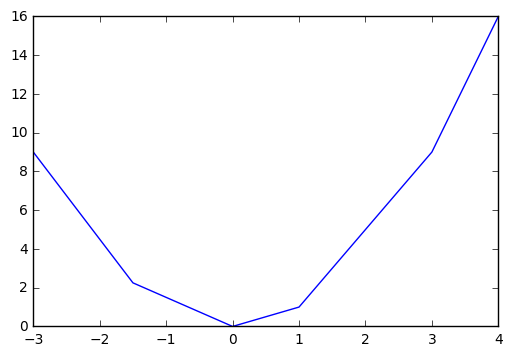

In [42]:
plt.plot(x, x ** 2)

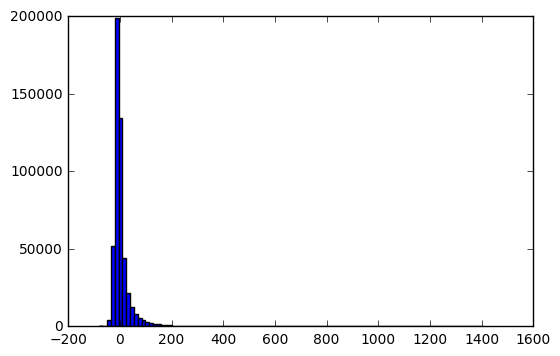

In [43]:
# histogram
plt.hist(target, bins=100)
pass # it is the way to suppress printing output of last line. pass = 'do nothing'

In [44]:
predictions = logreg_clf.predict_proba(testX.to_pandas())[:, 1]

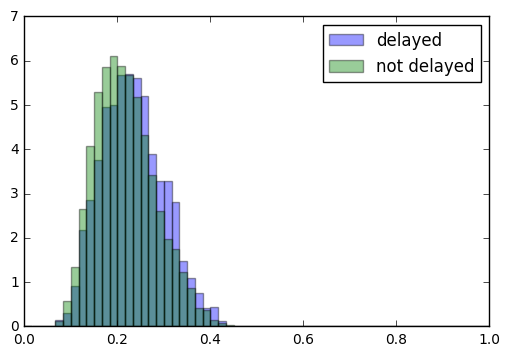

In [45]:
# several histograms all together
plt.hist(predictions[testY == 1], bins=60, alpha=0.4, normed=True, label='delayed', range=(0, 1));
plt.hist(predictions[testY == 0], bins=60, alpha=0.4, normed=True, label='not delayed', range=(0, 1));
plt.legend(loc='best');

(-10, 100)

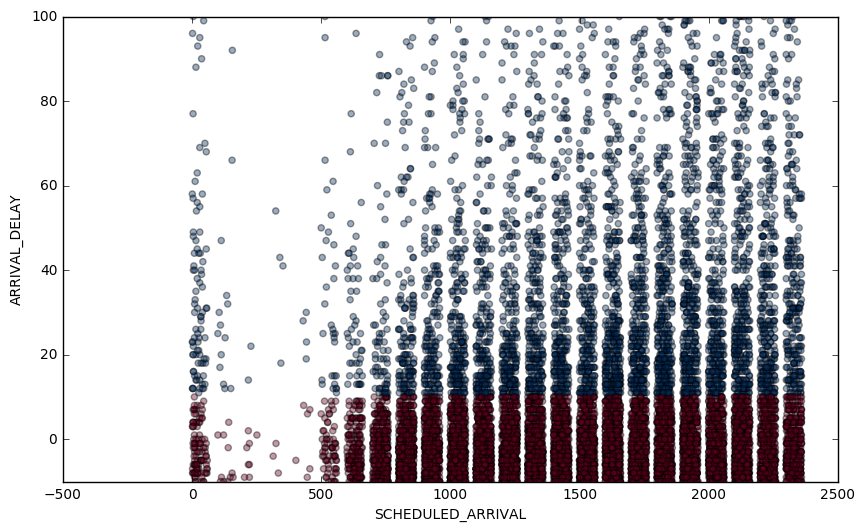

In [46]:
# Large scatter plot
plt.figure(figsize=[10, 6])
# binary target is used as color label
plt.scatter(small_data['SCHEDULED_ARRIVAL'], small_target, c=small_binary_target, alpha=0.4, 
            cmap='RdBu')
plt.xlabel('SCHEDULED_ARRIVAL')
plt.ylabel('ARRIVAL_DELAY')
plt.ylim(-10, 100)

Let's check if late flights are often delayed:

In [47]:
roc_auc_score(small_binary_target, small_data['SCHEDULED_ARRIVAL'])

0.58499117994221606

this feature is good to discriminate delayed and not delayed flights

### Plotting of roc curve

In [48]:
from sklearn.metrics import roc_curve
# the same arguments as in the roc_auc_score function
# returns false positive values (fpr), tru positive values (tpr), 
# and thresholds for which fpr and tpr are computed
fpr, tpr, _ = roc_curve(small_binary_target, small_data['SCHEDULED_ARRIVAL'])

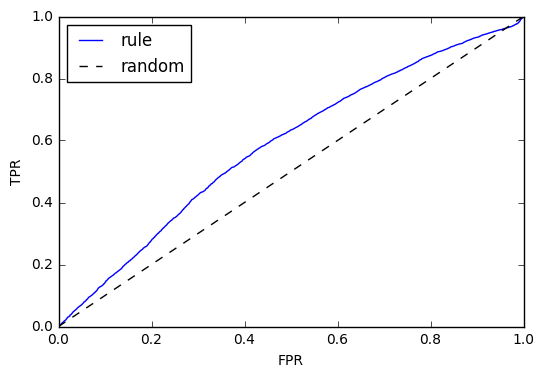

In [49]:
# plot roc curve - dependence between fpr and tpr
plt.plot(fpr, tpr, label='rule')
plt.xlabel('FPR')
plt.ylabel('TPR')
# plot roc curve for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='random')
plt.legend(loc='best')

## One-hot encoding

Let categorical feature provides values {x1, .., xN}. Encode these values with N binary derived inputs, one for each possible value of the original feature. This encoding scheme represents each value of the original categorical with a binary vector with the i-th component set to one, and the rest set to zero.

In [50]:
trainX.colnames

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE_ID',
 'FLIGHT_NUMBER_ID',
 'TAIL_NUMBER_ID',
 'ORIGIN_AIRPORT_ID',
 'DESTINATION_AIRPORT_ID',
 'SCHEDULED_DEPARTURE',
 'DISTANCE',
 'SCHEDULED_ARRIVAL']

In [51]:
categorical_features = ['ORIGIN_AIRPORT_ID', 'DESTINATION_AIRPORT_ID', 'TAIL_NUMBER_ID']
# all other features
non_categorical_features = list(set(trainX.columns) - set(categorical_features))

In [52]:
from sklearn.preprocessing import OneHotEncoder
# create encoder
coder = OneHotEncoder(sparse=True, handle_unknown='ignore')
# fit it
coder.fit(trainX[categorical_features].to_pandas())

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=True)

In [53]:
# transform categorical features into vectors with zeros and ones
trainX_sparse = coder.transform(trainX[categorical_features].to_pandas())
testX_sparse  = coder.transform(testX[categorical_features].to_pandas())

### output of one-hot is sparse ...

In [54]:
trainX_sparse

<12497x4950 sparse matrix of type '<type 'numpy.float64'>'
	with 37491 stored elements in Compressed Sparse Row format>

### Sparse matrices

somewhat you (probably) will need to work with the competition efficiently.


The scipy.sparse module provides data structures for 2D sparse matrices. There are [several](http://www.scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html) available sparse matrix types, we'll use two of them: 

1. csc_matrix: Compressed Sparse Column 
2. csr_matrix: Compressed Sparse Row 


In [55]:
# convert sparse matrix into dense matrix
trainX_sparse[:100].toarray() 

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [56]:
n_elements = trainX_sparse.shape[0] * trainX_sparse.shape[1]
n_nonzero_elements = trainX_sparse.getnnz()

# real amount of elements is ~1600 times less
print n_elements / float(n_nonzero_elements)

1650.0


In [57]:
trainX_sparse

<12497x4950 sparse matrix of type '<type 'numpy.float64'>'
	with 37491 stored elements in Compressed Sparse Row format>

### Adding new features

In [58]:
from scipy import sparse
# concatenate dense matrix and sparse matrix, result is a sparse matrix
# new_data = sparse.hstack([dense_numpy_matrix, sparce_matrix])

Many classifiers and regression models in sklearn can operate with sparse data

## Logistic regression on one-hot encoded data

In [59]:
logreg_clf = LogisticRegression(C=1)
logreg_clf.fit(trainX_sparse, trainY)
print roc_auc_score(testY,  logreg_clf.predict_proba(testX_sparse)[:, 1])

0.545664809239


In [60]:
# play with regularization, important due to high number of features
for C in [0.001, 0.01, 0.1, 1., 10., 100]:
    logreg_clf = LogisticRegression(C=C, solver='lbfgs', max_iter=3000, tol=1e-7)
    logreg_clf.fit(trainX_sparse, trainY)
    print C, roc_auc_score(testY, logreg_clf.predict_proba(testX_sparse)[:, 1])

0.001 0.552382385982
0.01 0.554204525793
0.1 0.555785637754
1.0 0.545750553552
10.0 0.534368398392
100 0.530710145081


# References

- [scipy documentation on sparse matrices](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)
    - more verbose reference can be found in [scipy lectures](http://www.scipy-lectures.org/advanced/scipy_sparse/index.html)
- stackoverflow is your best friend - almost any question is already answered there :)    
- ask in the gitter chat if you need something specific

** Major Goal in kaggle competition.** Provide best classification model for the problem!

You can start with:
1. Computing new features
    - for example, adding more one-hot encoded features
3. Use one-hot encoding for pairs of features (for example for origin and destination airport)
    - play with regularization during adding more one-hot encoded features!
5. Train regressors to predict exact arrival delay, not binary target?
6. Use more data to improve models discussed above (we used only 5%..)
7. and test your own ideas


Or start with changing parameters of classifiers. 